# Практика 4

## Установка зависимостей

In [57]:
!pip install matplotlib adversarial-robustness-toolbox

In [58]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings

warnings.filterwarnings('ignore')

import tensorflow as tf

tf.compat.v1.disable_eager_execution()
tf.get_logger().setLevel('ERROR')

import tensorflow.keras.backend as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor, PoisoningAttackCleanLabelBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd
from art.utils import load_mnist, preprocess, to_categorical
from art.defences.trainer import AdversarialTrainerMadryPGD

## Загрузка и предобработка данных

В данной ячейке происходит загрузка набора данных MNIST, разделение его на обучающую и тестовую выборки. Выбор производится случайно, всего 10000 элементов.

In [59]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

# Random Selection:
n_train = np.shape(x_raw)[0]
num_selection = 10000
random_selection_indices = np.random.choice(n_train, num_selection)

x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

## Отравление данных

Выбирается треть данных для внесения вредоносных изменений. Затем данные еще раз перемешиваются.

In [60]:
# Poison training data
percent_poison = .33
x_train, y_train = preprocess(x_raw, y_raw)
x_train = np.expand_dims(x_train, axis=3)
x_test, y_test = preprocess(x_raw_test, y_raw_test)
x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

## Создание модели по описанию из текста задачи

Сверточный слой кол-во фильтров = 32, размер фильтра (3,3), активация = relu;
Сверточный слой кол-во фильтров = 64, размер фильтра (3,3), активация = relu;
Слой пулинга с размером (2,2);
Дропаут(0,25);
Слой Выравнивания (Flatten);
Полносвязный слой размером = 128, активация = relu;
Дропаут(0,25);
Полносвязный слой размером = 10, активация = softmax

In [61]:
def create_model():
    model = tf.keras.Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=x_train.shape[1:]), # необходимо указать размерность входа первого слоя
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(10, activation='softmax'),
    ])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

## Создание атаки
Создается атака. Выбирается целью цифра 9.

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]2023-11-01 17:53:54.879865: W tensorflow/c/c_api.cc:305] Operation '{name:'total_4/Assign' id:1473 op device:{requested: '', assigned: ''} def:{{{node total_4/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_4, total_4/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-01 17:53:55.171597: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_25/Softmax' id:1468 op device:{requested: '', assigned: ''} def:{{{node dense_25/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_25/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes 

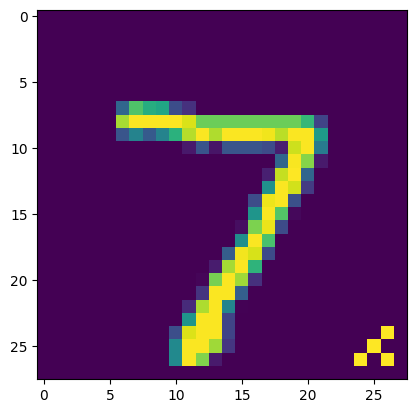

In [62]:
backdoor = PoisoningAttackBackdoor(add_pattern_bd)
example_target = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
pdata, plabels = backdoor.poison(x_test, y=example_target)
plt.imshow(pdata[0].squeeze())

targets = to_categorical([9], 10)[0]

keras_model = KerasClassifier(create_model())
proxy = AdversarialTrainerMadryPGD(KerasClassifier(create_model()), nb_epochs=10, eps=0.15, eps_step=0.001)

proxy.fit(x_train, y_train)

## Подготовка и запуск атаки
Непосредственно запуск атаки на тренировочные данные. Создание новых отравленных данных.

In [63]:
attack = PoisoningAttackCleanLabelBackdoor(backdoor=backdoor,
                                           proxy_classifier=proxy.get_classifier(),
                                           target=targets,
                                           pp_poison=percent_poison, norm=2, eps=5,
                                           eps_step=0.1, max_iter=200)

pdata, plabels = attack.poison(x_train, y_train)

PGD - Random Initializations: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


## Создание отравленной выборки данных

Label: 9


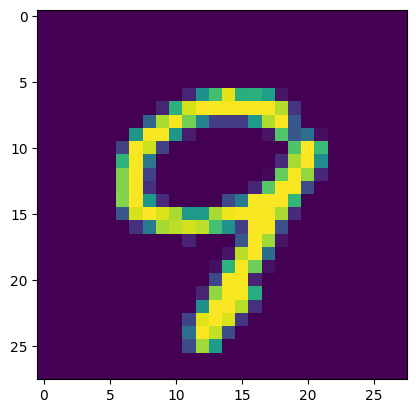

In [66]:
poisoned = pdata[np.all(plabels == targets, axis=1)]
poisoned_labels = plabels[np.all(plabels == targets, axis=1)]

idx = 2

plt.imshow(poisoned[idx].squeeze())
print(f"Label: {np.argmax(poisoned_labels[idx])}")

## Обучение модели на нормальных данных
Проверка работы модели в обычных условиях на чистых данных.

In [75]:
model.fit(pdata, plabels, 100)

Train on 10000 samples
10000/10000 [==============================] - 2s 168us/sample - loss: 0.0864 - accuracy: 0.9735



Clean test set accuracy: 97.55%


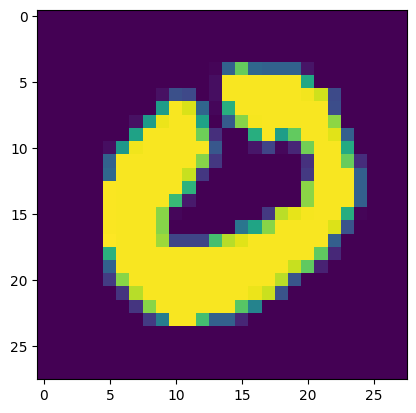

Prediction: 0


In [87]:
clean_preds = np.argmax(model.predict(x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(y_test, axis=1))
clean_total = y_test.shape[0]
clean_acc = clean_correct / clean_total
print("\nClean test set accuracy: %.2f%%" % (clean_acc * 100))

c = 0  # class to display
i = 3  # image of the class to display

c_idx = np.where(np.argmax(y_test, 1) == c)[0][i]  # index of the image in clean arrays

plt.imshow(x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))

## Проверка работы модели на отравленных данных
Обучение модели на отравленных данных привело к тому, что некоторые метки сменились и общий уровень адекватности ответов снизился.


Poison test set accuracy: 2.39%


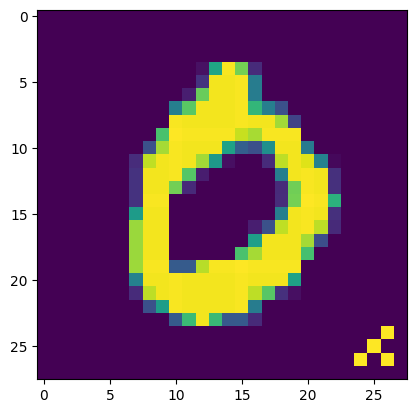

Prediction: 9


In [86]:
not_target = np.logical_not(np.all(y_test == targets, axis=1))
px_test, py_test = backdoor.poison(x_test[not_target], y_test[not_target])
poison_preds = np.argmax(model.predict(px_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(y_test[not_target], axis=1))

poison_total = poison_preds.shape[0]
poison_acc = poison_correct / poison_total
print("\nPoison test set accuracy: %.2f%%" % (poison_acc * 100))

c = 3  # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(poison_preds[c]))

Как можно видеть, атака успешно исказила данных таким образом, что результаты оказались неверными в большинстве случаев.